In [1]:
# Install the necessary libraries
!pip install gdown

# Download the dataset zip file from Google Drive
!gdown --id 1yID2SmoLh2QTGXNbtegaMQ2PJfVpfB5E -O dataset.zip

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:130: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From (uriginal): https://drive.google.com/uc?id=1yID2SmoLh2QTGXNbtegaMQ2PJfVpfB5E
From (redirected): https://drive.google.com/uc?id=1yID2SmoLh2QTGXNbtegaMQ2PJfVpfB5E&confirm=t&uuid=0dfa560a-d151-4b5a-8ae4-5e09c3d22404
To: /kaggle/working/dataset.zip
100%|███████████████████████████████████████| 2.94G/2.94G [00:24<00:00, 121MB/s]


In [3]:
!unzip "/kaggle/working/dataset.zip"

Archive:  /kaggle/working/dataset.zip
   creating: DATASET/PNEUMONIA_NEGATIVE/
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000002_000.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000005_000.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000005_001.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000005_002.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000005_003.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000005_004.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000005_005.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000006_000.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000007_000.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000008_001.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000011_001.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000011_002.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000011_003.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000011_004.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000011_008.png  
  inflating: DATASET/PNEUMONIA_NEGAT

In [4]:
import os
import numpy as np
import random
import cv2
from sklearn.model_selection import train_test_split

# Define the directory paths for the positive and negative pneumonia images
pneumonia_positive_dir = '/kaggle/working/DATASET/PNEUMONIA_POSITIVE'
pneumonia_negative_dir = '/kaggle/working/DATASET/PNEUMONIA_NEGATIVE'

# Define the image size
img_size = 224

# Create empty arrays to store the images and labels
images = []
labels = []

# Load the positive pneumonia images
for filename in os.listdir(pneumonia_positive_dir):
    img = cv2.imread(os.path.join(pneumonia_positive_dir, filename))
    img = cv2.resize(img, (img_size, img_size))
    images.append(img)
    labels.append(1)  # Positive label

# Load the negative pneumonia images
for filename in os.listdir(pneumonia_negative_dir):
    img = cv2.imread(os.path.join(pneumonia_negative_dir, filename))
    img = cv2.resize(img, (img_size, img_size))
    images.append(img)
    labels.append(0)  # Negative label

# Convert the images and labels to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Shuffle the dataset
random.seed(42)
idx = np.arange(len(images))
random.shuffle(idx)
images = images[idx]
labels = labels[idx]

# Divide the dataset into training, testing, and validation sets using an 80/10/10 split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1111, random_state=42, stratify=y_train)

# Print the size of each set
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Testing set size:", X_test.shape[0])


Training set size: 8000
Validation set size: 1000
Testing set size: 1000


In [5]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range = 30, 
    zoom_range = 0.2, 
    width_shift_range=0.1,  
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=True)

# Create the training generator
train_generator = datagen.flow(X_train, y_train, batch_size=32)


In [6]:
import tensorflow 
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

In [25]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

# Load the ResNet50V2 model
base_model = ResNet50V2(weights='imagenet', input_shape=(224, 224, 3),
                        pooling='max', include_top=False, classes=2)

for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential()
model.add(base_model)

model.add(Flatten())

model.add(Dense(128, activation = "relu"))
model.add(Dense(64, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [26]:
history = model.fit_generator(train_generator, epochs = 15, validation_data = (X_val, y_val), steps_per_epoch = 100)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/15
100/100 [==============================] - 47s 426ms/step - loss: 11.5153 - accuracy: 0.7563 - val_loss: 0.9482 - val_accuracy: 0.9090
Epoch 2/15
100/100 [==============================] - 39s 389ms/step - loss: 1.9706 - accuracy: 0.8213 - val_loss: 1.3584 - val_accuracy: 0.8520
Epoch 3/15
100/100 [==============================] - 38s 380ms/step - loss: 1.8024 - accuracy: 0.8294 - val_loss: 1.4390 - val_accuracy: 0.8150
Epoch 4/15
100/100 [==============================] - 41s 407ms/step - loss: 1.4915 - accuracy: 0.8325 - val_loss: 2.2111 - val_accuracy: 0.7880
Epoch 5/15
100/100 [==============================] - 38s 379ms/step - loss: 0.6920 - accuracy: 0.8847 - val_loss: 0.6787 - val_accuracy: 0.8740
Epoch 6/15
100/100 [==============================] - 41s 405ms/step - loss: 0.6207 - accuracy: 0.8750 - val_loss: 0.3523 - val_accuracy: 0.9220
Epoch 7/15
100/100 [==============================] - 39s 386ms/step - loss: 0.6117 - accuracy: 0.8791 - val_loss: 0.2499 - val_a

In [27]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")
print("The testing loss is: ", test_loss * 100, "%")

50/50 [==============================] - 3s 61ms/step - loss: 0.1737 - accuracy: 0.9380
The testing accuracy is:  93.80000233650208 %
The testing loss is:  17.37266033887863 %


32/32 [==============================] - 3s 85ms/step


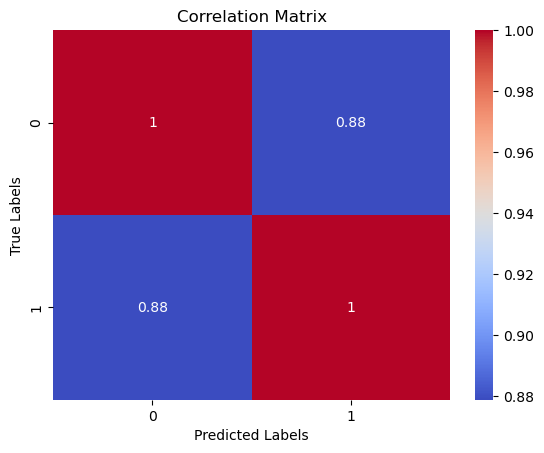

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get the predictions on the validation set
y_pred = model.predict(X_val)

# Convert probabilities to class labels
y_pred_classes = np.round(y_pred)

# Compute the correlation matrix
corr_matrix = np.corrcoef(y_val.T, y_pred_classes.T)

# Create a heatmap plot of the correlation matrix
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [29]:
# Convert the predicted probabilities to binary labels (0 or 1) using a threshold of 0.5
y_pred_binary = (y_pred >= 0.5).astype(int)

# Count the number of positives and negatives
num_positives = np.sum(y_pred_binary)
num_negatives = len(y_pred_binary) - num_positives

print("Number of predicted positives:", num_positives)
print("Number of predicted negatives:", num_negatives)


Number of predicted positives: 447
Number of predicted negatives: 553


In [30]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score


# Predict on the test set
preds = model.predict(X_test)
y_pred = []
for prob in preds:
    if prob >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

y_pred = np.array(y_pred)

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))

32/32 [==============================] - 3s 85ms/step
Accuracy: 0.9380
Precision: 0.8976
Recall: 0.9649


32/32 [==============================] - 3s 84ms/step



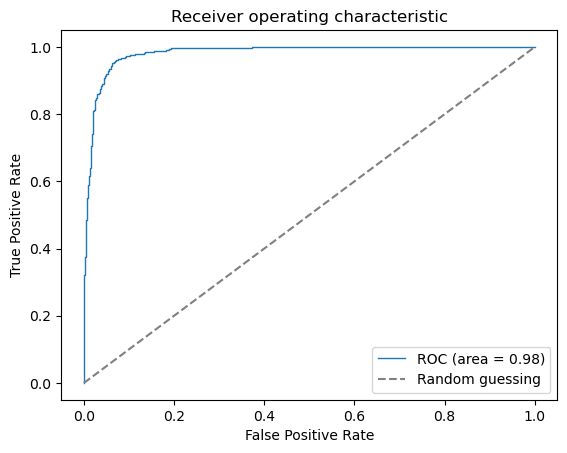

In [31]:
from sklearn.metrics import roc_curve, auc

# Make predictions on the test set
y_pred = model.predict(X_test)

# Compute the ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

print()
# Plot the ROC curve
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random guessing')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [32]:
import random
import matplotlib.pyplot as plt
import numpy as np


def random_image_prediction():
  # Load the image
  import os
  image_names = os.listdir('/kaggle/working/DATASET/PNEUMONIA_POSITIVE')

  # Select a random image file
  random_file = random.choice(image_names)

  # Load the image using the `cv2.imread()` function
  image = cv2.imread("/kaggle/working/DATASET/PNEUMONIA_POSITIVE/" + random_file)

  # Resize the image
  image = cv2.resize(image, (224, 224))

  # Reshape the image to have a batch dimension
  image = np.expand_dims(image, axis=0)

  # Make predictions on the image
  pred = model.predict(image)

  # Print the predicted probability of the positive class
  print(pred[0][0])

  if (pred[0][0] > 0.5):
    print("Positive")
  else:
    print("Negative")


print('1.')
random_image_prediction()
print('')
print('2.')
random_image_prediction()
print('') 
print('3.')
random_image_prediction()


1.
1/1 [==============================] - 0s 30ms/step
0.999044
Positive

2.
1/1 [==============================] - 0s 30ms/step
0.9994653
Positive

3.
1/1 [==============================] - 0s 30ms/step
0.99264175
Positive


In [33]:
import random
import numpy as np


def random_image_prediction():
  # Load the image
  import os
  image_names = os.listdir('/kaggle/working/DATASET/PNEUMONIA_NEGATIVE')

  # Select a random image file
  random_file = random.choice(image_names)

  # Load the image using the `cv2.imread()` function
  image = cv2.imread("/kaggle/working/DATASET/PNEUMONIA_NEGATIVE/" + random_file)

  # Resize the image
  image = cv2.resize(image, (224, 224))

  # Reshape the image to have a batch dimension
  image = np.expand_dims(image, axis=0)

  # Make predictions on the image
  pred = model.predict(image)

  # Print the predicted probability of the positive class
  print(pred[0][0])

  if (pred[0][0] > 0.5):
    print("Positive")
  else:
    print("Negative")


print('1.')
random_image_prediction()
print('')
print('2.')
random_image_prediction()
print('') 
print('3.')
random_image_prediction()


1.
1/1 [==============================] - 0s 33ms/step
4.0970035e-06
Negative

2.
1/1 [==============================] - 0s 29ms/step
0.008418441
Negative

3.
1/1 [==============================] - 0s 29ms/step
4.001273e-06
Negative
